# **Import Libraries**

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
import mediapipe

# **Data Loading Functions**

In [4]:
def load_video(video_path):
    import tensorflow as tf
    import cv2

    # Decode path from tf.string Tensor
    path = video_path.numpy().decode("utf-8")
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (64, 64))              # use OpenCV to resize here
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)         # (64, 64)
        frame = np.expand_dims(frame, axis=-1)                  # (64, 64, 1)

        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return np.zeros((50, 64, 64, 1), dtype=np.float32)

    frames = np.stack(frames).astype(np.float32)
    num_frames = frames.shape[0]

    if num_frames > 50:
        frames = frames[:50]
    elif num_frames < 50:
        padding = np.zeros((50 - num_frames, 64, 64, 1), dtype=np.float32)
        frames = np.concatenate([frames, padding], axis=0)

    mean = np.mean(frames)
    std = np.std(frames)
    frames = (frames - mean) / (std + 1e-6)

    return frames.astype(np.float32)


In [5]:
# 2. Label Extractor
def extract_label(video_path):
    filename = os.path.basename(video_path.numpy().decode("utf-8"))
    word = filename.split("_")[1].strip()
    class_names = [f'w{i}' for i in range(1, 21)]
    return class_names.index(word)

In [6]:
# 3. Wrapper using py_function
def load_video_and_label(path):
    frames = tf.py_function(load_video, [path], tf.float32)
    frames.set_shape((50, 64, 64, 1))

    label = tf.py_function(extract_label, [path], tf.int64)
    label.set_shape([])

    return frames, label

# **Data Pipeline**

In [7]:
base_paths = tf.data.Dataset.list_files(
    '/kaggle/input/mlrd-20/videos/*_*_base.mp4',
    shuffle=False
)
lighten_paths = tf.data.Dataset.list_files(
    '/kaggle/input/mlrd-20/videos/*_*_lighten.mp4',
    shuffle=False
)
darken_paths = tf.data.Dataset.list_files(
    '/kaggle/input/mlrd-20/videos/*_*_darken.mp4',
    shuffle=False
)
video_paths = base_paths.concatenate(lighten_paths).concatenate(darken_paths)
video_paths = video_paths.shuffle(500, reshuffle_each_iteration=True)

dataset = video_paths.map(load_video_and_label, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1747799067.954792      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
len(dataset)

36

In [9]:
# Train Test Split
train_dataset = dataset.take(30)
test_dataset = dataset.skip(30)

# **Model Defination**

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_3dcnn_blstm_model(input_shape=(50, 64, 64, 1), num_classes=20):
    inputs = tf.keras.Input(shape=input_shape)

    # 3D CNN Feature Extractor
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)

    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)  # reduces temporal dim

    # Shape before reshape: (batch, time, h, w, c)
    # We collapse spatial dims and keep temporal as sequence
    x = layers.Reshape((x.shape[1], -1))(x)  # (time, features)

    # BiLSTM Layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    # Classifier
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Instantiate
model = build_3dcnn_blstm_model()

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 64, 64, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 50, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 50, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 50, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 32, 32, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 25, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 25, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 16, 16, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 12, 8, 8, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 12, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 12, 256)             │       8,520,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,982,612 (34.27 MB)

 Trainable params: 8,982,164 (34.26 MB)

 Non-trainable params: 448 (1.75 KB)

# **Model Compile and Callbacks**

In [11]:
import tensorflow as tf
import os
from datetime import datetime

# Rebuild the model
model = build_3dcnn_blstm_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Directory to save checkpoints
checkpoint_dir = 'checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# TensorBoard log directory
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))

class StopAtValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.95):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} validation accuracy. Stopping training.")
            self.model.stop_training = True


# Define Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    StopAtValAccuracy(target=0.95)  # <-- custom stopping condition
]

# **Train Model**

In [12]:
# 🚀 Train
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1747799081.099411     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0439 - loss: 3.0428
Epoch 1: val_accuracy improved from -inf to 0.06111, saving model to checkpoints/best_model.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.0438 - loss: 3.0424 - val_accuracy: 0.0611 - val_loss: 3.0004
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0583 - loss: 3.0006
Epoch 2: val_accuracy did not improve from 0.06111
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0581 - loss: 3.0008 - val_accuracy: 0.0583 - val_loss: 3.0242
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0630 - loss: 2.9966
Epoch 3: val_accuracy did not improve from 0.06111
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.0629 - loss: 2.9966 - val_accuracy: 0.0611 - val_loss: 3.0164
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0480 - loss: 2.9988
Epoch 4: val_accuracy did not improve from 0.06111
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0480 - loss: 2.9988 - val_accurac

# **Save Weights and History**

In [13]:
import pandas as pd
history_df = pd.DataFrame(history.history)

In [14]:
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.040625,3.029605,0.061111,3.000353
1,0.051562,3.005948,0.058333,3.024247
2,0.057292,2.997027,0.061111,3.016361
3,0.048958,2.998966,0.047222,3.031856
4,0.051042,2.992752,0.052778,3.024673
5,0.057292,2.993320,0.044444,3.004364
6,0.067708,2.992866,0.038889,3.010970
7,0.065625,2.984413,0.047222,3.003714
8,0.068750,2.983417,0.061111,2.996962
9,0.072917,2.966727,0.091667,2.974679


In [15]:
history_df.to_csv("model_history.csv")

In [16]:
# Save weights to an HDF5 file
model.save_weights('best_model.weights.h5')


In [ ]:
# Save model to an HDF5 file
model.save('lipreading_model.h5')

# **Evalution**

In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for videos, labels in test_dataset:
    preds = model.predict(videos)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        14
           2       1.00      0.90      0.95        21
           3       0.95      1.00      0.97        19
           4       0.86      1.00      0.93        19
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        19
           7       0.85      0.94      0.89        18
           8       0.92      1.00      0.96        24
           9       1.00      0.82      0.90        17
          10       1.00      0.86      0.92        14
          11       0.84      0.89      0.86        18
          12       0.84      1.00      0.91        16
         

In [18]:
# 🧪 Evaluate
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 649ms/step - accuracy: 0.9462 - loss: 0.2061

✅ Test Accuracy: 0.9444


# **Plots**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

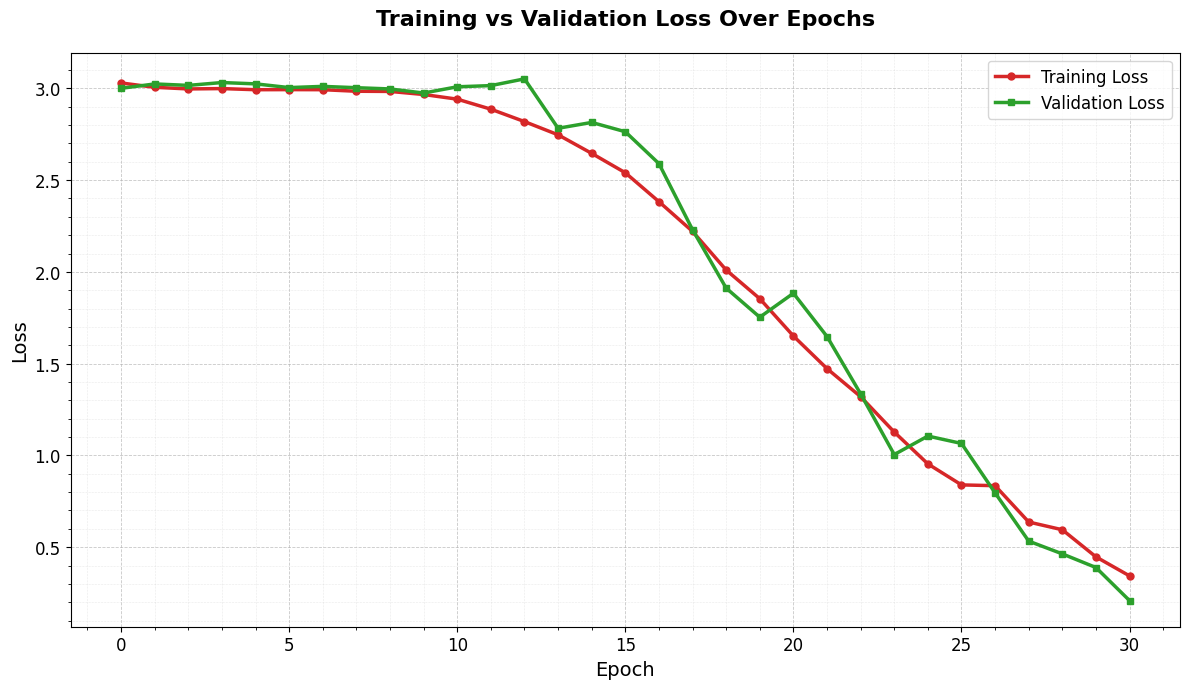

In [20]:
import matplotlib.pyplot as plt

# Improved Plot: Training and Validation Loss with Fine Grid
plt.figure(figsize=(12, 7))

# Plot training loss
plt.plot(history_df['loss'], label='Training Loss',
         linewidth=2.5, marker='o', markersize=5, color='#d62728')

# Plot validation loss if available
if 'val_loss' in history_df:
    plt.plot(history_df['val_loss'], label='Validation Loss',
             linewidth=2.5, marker='s', markersize=5, color='#2ca02c')

# Titles and labels
plt.title('Training vs Validation Loss Over Epochs', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Major and minor gridlines for finer detail
plt.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

# Legend and ticks
plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("loss_plot.png", format='png', dpi=300)
plt.show()

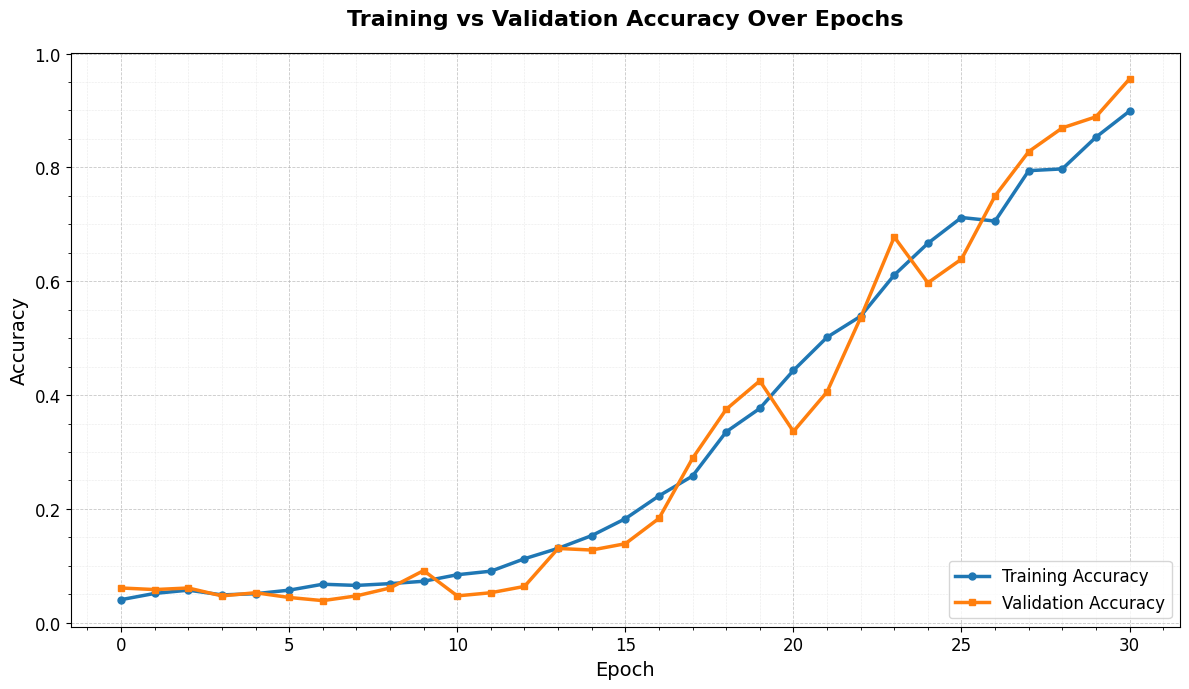

In [21]:
import matplotlib.pyplot as plt

# Improved Plot: Training and Validation Accuracy with Fine Grid
plt.figure(figsize=(12, 7))

# Plot training accuracy
plt.plot(history_df['accuracy'], label='Training Accuracy',
         linewidth=2.5, marker='o', markersize=5, color='#1f77b4')

# Plot validation accuracy if available
if 'val_accuracy' in history_df:
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy',
             linewidth=2.5, marker='s', markersize=5, color='#ff7f0e')

# Titles and labels
plt.title('Training vs Validation Accuracy Over Epochs', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Major and minor gridlines
plt.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

# Legend and ticks
plt.legend(fontsize=12, loc='lower right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("accuracy_plot.png", format='png', dpi=300)
plt.show()

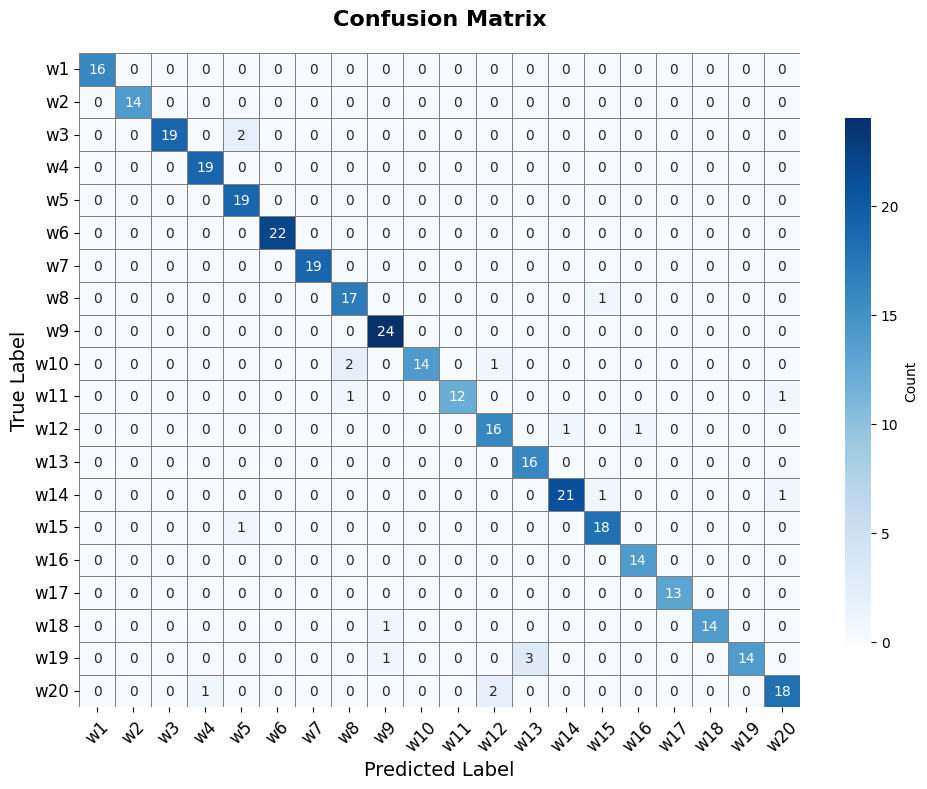

In [22]:
# Generate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Generate class names as w1, w2, ..., wN
num_classes = cm.shape[0]
class_names = [f"w{i+1}" for i in range(num_classes)]

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar_kws={"shrink": 0.8, "label": "Count"}, linewidths=0.5, linecolor='gray')

plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.grid(False)
plt.savefig("confusion_matrix.png", format='png', dpi=300)
plt.show()

# **Test**

In [24]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/kaggle/working/lipreading_model.h5")

In [25]:
loaded_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 633ms/step - accuracy: 0.9380 - loss: 0.2321


[0.24096013605594635, 0.9361110925674438]